In [1]:
import re
import csv 
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
%matplotlib inline

class Compound:
    def __init__(self,
                formulas = [],
                adducts = [],
                description = "",
                precursor_mz = 0.0,
                charge = "",
                rt = "",
                fragment_mz = [],
                fragment_int = []):
        self.formulas = formulas
        self.adducts = adducts
        self.description = description
        self.precursor_mz = precursor_mz
        self.charge = charge
        self.rt = rt
        self.fragment_mz = fragment_mz
        self.fragment_int = fragment_int
        
class Matches:
    def __init__(self,
                 overlapping_oms = [],
                 non_overlapping_oms = [],
                 overlapping_mdia = [],
                 non_overlapping_mdia = [],
                 overlapping_rt_dict = {},
                 overlapping_formula_dict = {}):
        self.overlapping_oms = overlapping_oms
        self.non_overlapping_oms = non_overlapping_oms
        self.overlapping_mdia = overlapping_mdia
        self.non_overlapping_mdia = non_overlapping_mdia
        self.overlapping_rt_dict = overlapping_rt_dict
        self.overlapping_formula_dict = overlapping_formula_dict
        
def useCompoundMass(compound):
    return compound.precursor_mz

def read_metabodia_library(in_library_path):
    compoundlist = []
    description = ""

    file = open(in_library_path, 'r')
    line = file.readline()
    index = 0
    while line: 
        line = line.strip()
        lastlineoffileemtpy = len(line.strip()) == 0
        if line.startswith("Putative_formula_MS1:") or lastlineoffileemtpy:
            if (index == 0):
                compound = Compound()
            if (description != ""):
                compoundlist.append(compound)
                compound = Compound()
                compound.formulas = []
                compound.adducts = []
                compound.fragment_mz = []
                compound.fragment_int = []
            description = line.split(" ")[1].strip()
            compound.description = description
            for element in description.split(";"):
                index_1 = element.index("^")
                index_2 = element.index("_")
                compound.formulas.append(element[0:index_1])
                compound.adducts.append(str("[" + element[index_1+1:index_2] + "]+")) # TODO: Not sure if that works for all cases. Here only charge 1. 
        if line.startswith("Precursor m/z:"):
            compound.precursor_mz = float(line.split(" ")[2])
        if line.startswith("Charge state:"):
            compound.charge = line.split(" ")[2]
        if line.startswith("RT:"):
            compound.rt = line.split(" ")[1]
        if line.startswith(tuple('0123456789')):
            compound.fragment_mz.append(line.split("\t")[0].strip())
            compound.fragment_int.append(line.split("\t")[1].strip("\n").strip())
        line = file.readline()
        index += 1

    file.close()
    compoundlist.sort(key=useCompoundMass)
    return(compoundlist)

def read_openms_assay_library(openmslib_path):
    compoundlist = []
    d_lib = dict()
    df_assay_lib = pd.read_csv(openmslib_path, sep = '\t')

    # filter decoys
    df_assay_lib = df_assay_lib[df_assay_lib['Decoy'] == 0]

    unique_tgid = df_assay_lib.TransitionGroupId.unique()
    for element in unique_tgid:
        d_lib[element] = df_assay_lib[df_assay_lib['TransitionGroupId'] == element]

    for key, value in d_lib.items():
        compound = Compound()
        # filter empty entries 
        if not value['SumFormula'].unique(): 
            continue
        compound.formulas = value['SumFormula'].unique()
        compound.adducts = value['Adducts'].unique()
        compound.description = value['CompoundName'].unique()[0]
        compound.precursor_mz = value['PrecursorMz'].unique()[0]
        compound.charge = value['PrecursorCharge'].unique()[0]
        compound.rt = value['NormalizedRetentionTime'].unique()[0]
        compound.fragment_mz = value['ProductMz'].tolist()
        compound.fragment_int = value['LibraryIntensity'].tolist()
        compoundlist.append(compound)
    
    compoundlist.sort(key=useCompoundMass)
    return compoundlist

def writeMapping(matches, output_path):
    csv_columns = ['mdia_formula', 'oms_formula']
    csv_file = output_path
    with open(csv_file, 'w') as csvfile:
        csvfile.write("mdia_formula\toms_formula\n")
        for key in matches.overlapping_formula_dict.keys():
            csvfile.write("%s\t%s\n"%(key,matches.overlapping_formula_dict[key]))
    csvfile.close()

# intPrecurorMz_Sumformula_Adduct
def extractUniqueIdentifiers(compound_list):
    compound_keys = []
    for element in compound_list:
        if len(element.formulas) == len(element.adducts):
            same_compound = []
            for i in range(0,len(element.formulas)):
                same_compound.append(str(str(int(element.precursor_mz)) + "_" + str(element.formulas[i]) + "_" + str(element.adducts[i])))
            compound_keys.append(same_compound)
        else:
            print("There seem to be something wrong!")
    return compound_keys

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

# intPrecurorMz_Sumformula_Adduct
def extractPrecursorMzWithNDecimals(compound_list, decimals):
    compound_keys = []
    for element in compound_list:
        compound_keys.append(truncate(element.precursor_mz, decimals))
    return compound_keys

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# comparison based on molecular_formula, adduct and the retention time 
def compareBySumAddRt(mdia_lib, oms_lib, rt_dev):
    oms_dict = {}
    for compound in oms_lib:
        # index 0, since oms only one formula and adduct
        key = str(compound.formulas[0] + "_" + compound.adducts[0])
        new_value = []
        new_value.append(compound.rt)
        if key in oms_dict:
            current_value = oms_dict[key]
            combined_value = current_value + new_value
            oms_dict[key] = combined_value
        else:
            oms_dict[key] = new_value

    overlapping_rt_dict = {}  
    overlapping_formula_dict = {}
    not_in_dictionary = [] # compounds which had no match 
    in_dictionary = [] # compounds which had a match
    valid_lookup_keys = [] # key which had a match in the oms_dict
    for compound in mdia_lib:
        l_size = len(compound.formulas)
        for i in range(0,l_size):
            key = str(compound.formulas[i] + "_" + compound.adducts[i])
            #print(key)
            if key in oms_dict:
                current_entry = oms_dict[key]
                #print(current_entry)
                # iterate over rt in dict_oms
                for j in range(0,len(current_entry)):
                    # check if retention time within a certain threshold
                    min_rt = current_entry[j] - rt_dev
                    max_rt = current_entry[j] + rt_dev
                    #print("c_entry: " + str(current_entry[j]))
                    #print("m_entry: " + str(compound.rt))
                    #print("min_rt: " + str(min_rt))
                    #print("max_rt: " + str(max_rt))
                    rt_bool = float(compound.rt) >= float(min_rt) and float(compound.rt) <= float(max_rt)
                    #print(rt_bool)
                    if (rt_bool):
                        des = []
                        descriptions = compound.description.split(";")
                        for element in descriptions:
                            des.append(re.sub("_.*$","",element))
                        description = ';'.join(des)
                        if compound.rt in overlapping_rt_dict:
                            overlapping_rt_dict[compound.rt].append(current_entry[j])
                        else:
                            l_rt = [current_entry[j]]
                            overlapping_rt_dict[compound.rt] = l_rt  
                        if description in overlapping_formula_dict:
                            overlapping_formula_dict[description].append(str(key))
                        else:
                            l_key = [str(key)]
                            overlapping_formula_dict[description] = l_key
                        in_dictionary.append(compound) # save mdia entry ## TODO happens to often 
                        lookup_key = str(str(key) + "_" + str(current_entry[j]))
                        valid_lookup_keys.append(lookup_key)

    # Resolve overlapping / non_overlapping compounds in oms
    overlapping_compounds_oms = []
    non_overlapping_compounds_oms = []
    for compound in oms_lib:
        lookup = str(compound.formulas[0] + "_" + compound.adducts[0] + "_" + str(compound.rt))
        if lookup in valid_lookup_keys:
            overlapping_compounds_oms.append(compound)
        else:
            non_overlapping_compounds_oms.append(compound)

    # Resolve overlapping / non_overlapping compounds in mdia 
    overlapping_compounds_mdia = []
    non_overlapping_compounds_mdia = []
    in_dictionary = set(in_dictionary)
    for compound in mdia_lib:
        if compound in in_dictionary:
            overlapping_compounds_mdia.append(compound)
        else:
            non_overlapping_compounds_mdia.append(compound)
            
    matches = Matches()
    matches.overlapping_oms = overlapping_compounds_oms
    matches.non_overlapping_oms = non_overlapping_compounds_oms
    matches.overlapping_mdia = overlapping_compounds_mdia
    matches.non_overlapping_mdia = non_overlapping_compounds_mdia
    matches.overlapping_rt_dict = overlapping_rt_dict
    matches.overlapping_formula_dict = overlapping_formula_dict
    
    return matches

def checkStillOverlappingByMzRt(matches, ppm_dev, rt_dev):
    overlapping_mdia = []
    overlapping_oms = []
    for c_mdia in matches.non_overlapping_mdia:
        for c_oms in matches.non_overlapping_oms:
            min_rt = c_oms.rt - rt_dev
            max_rt = c_oms.rt + rt_dev
            mz_uncertainty = float(c_oms.precursor_mz) * float(ppm_dev) * 1e-6
            min_mz = float(c_oms.precursor_mz) - mz_uncertainty
            max_mz = float(c_oms.precursor_mz) + mz_uncertainty
            rt_bool = float(c_mdia.rt) >= float(min_rt) and float(c_mdia.rt) <= float(max_rt)
            mz_bool = float(c_mdia.precursor_mz) >= float(min_mz) and float(c_mdia.precursor_mz) <= float(max_mz)
            if (rt_bool and mz_bool):
                overlapping_oms.append(c_oms)
                overlapping_mdia.append(c_mdia)
            
    match_mz_rt = Matches()
    match_mz_rt.overlapping_oms = overlapping_oms
    match_mz_rt.overlapping_mdia = overlapping_mdia
    return match_mz_rt

####### input paths #######
metabodialib_00 = "/Volumes/elements/MetaboDIA/comparison/metabodia/DDA_msconvert_mzXML_10ppm_min_s00001_pf00.txt"
metabodialib_02 = "/Volumes/elements/MetaboDIA/comparison/metabodia/DDA_msconvert_mzXML_10ppm_min_s02_pf00.txt"
metabodialib_05 = "/Volumes/elements/MetaboDIA/comparison/metabodia/DDA_msconvert_mzXML_10ppm_min_s05_pf00.txt"

comb_lib_00 = "/Volumes/elements/MetaboDIA/Option_1/combined_library_00/20201215_combined_mdiaoms_library_67_00.tsv"
comb_lib_02 = "/Volumes/elements/MetaboDIA/Option_1/combined_library_02_67/prepare_lib/20201215_combined_mdiaoms_library_67.tsv"
comb_lib_05 = "/Volumes/elements/MetaboDIA/Option_1/combined_library_05/20201215_combined_mdiaoms_library_67_05.tsv"

openmslib_mt1_s45_00 = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_totoc_67_00.tsv"
openmslib_mt1_s45_02 = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_totoc_67_02.tsv"
openmslib_mt1_s45_05 = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_totoc_67_05.tsv"

openmslib_mt1_s45_00_uk = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_unknown_totoc_00.tsv"
openmslib_mt1_s45_02_uk = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_unknown_totoc_67_02.tsv"
openmslib_mt1_s45_05_uk = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_unknown_totoc_05.tsv"


####### read the libraries #######
# metabodia
metabodialib_00_cl = read_metabodia_library(metabodialib_00)
print("metabodialib_00_cl: " + str(len(metabodialib_00_cl)))
metabodialib_02_cl = read_metabodia_library(metabodialib_02)
print("metabodialib_02_cl: " + str(len(metabodialib_02_cl)))
metabodialib_05_cl = read_metabodia_library(metabodialib_05)
print("metabodialib_05_cl: " + str(len(metabodialib_05_cl)))

## count mz <= 3 
count_compounds_less_3_fragments_00 = 0
metabodialib_00_l = []
for element in metabodialib_00_cl:
    if len(element.fragment_mz) < 3:
        count_compounds_less_3_fragments_00 +=1
    else:
        metabodialib_00_l.append(element)
print("count_compounds_less_3_fragments_00: " + str(count_compounds_less_3_fragments_00))

count_compounds_less_3_fragments_02 = 0
metabodialib_02_l = []
for element in metabodialib_02_cl:
    if len(element.fragment_mz) < 3:
        count_compounds_less_3_fragments_02 +=1
    else:
        metabodialib_02_l.append(element)
print("count_compounds_less_3_fragments_02: " + str(count_compounds_less_3_fragments_02))

count_compounds_less_3_fragments_05 = 0
metabodialib_05_l = []
for element in metabodialib_05_cl:
    if len(element.fragment_mz) < 3:
        count_compounds_less_3_fragments_05 +=1
    else:
        metabodialib_05_l.append(element)
print("count_compounds_less_3_fragments_05: " + str(count_compounds_less_3_fragments_05))

comp_mt1_00_l = read_openms_assay_library(comb_lib_00)
print("comp_mt1_00_l: " + str(len(comp_mt1_00_l)))
comp_mt1_02_l = read_openms_assay_library(comb_lib_02)
print("comp_mt1_02_l: " + str(len(comp_mt1_02_l)))
comp_mt1_05_l = read_openms_assay_library(comb_lib_05)
print("comp_mt1_05_l: " + str(len(comp_mt1_05_l)))

# known
openmslib_mt1_s45_00_l = read_openms_assay_library(openmslib_mt1_s45_00)
print("openmslib_mt1_s45_00_l: " + str(len(openmslib_mt1_s45_00_l)))
openmslib_mt1_s45_02_l = read_openms_assay_library(openmslib_mt1_s45_02)
print("openmslib_mt1_s45_02_l: " + str(len(openmslib_mt1_s45_02_l)))
openmslib_mt1_s45_05_l = read_openms_assay_library(openmslib_mt1_s45_05)
print("openmslib_mt1_s45_05_l: " + str(len(openmslib_mt1_s45_05_l)))

# unknown
openmslib_mt1_s45_00_uk_l = read_openms_assay_library(openmslib_mt1_s45_00_uk)
print("openmslib_mt1_s45_00_uk_l: " + str(len(openmslib_mt1_s45_00_uk_l)))
openmslib_mt1_s45_02_uk_l = read_openms_assay_library(openmslib_mt1_s45_02_uk)
print("openmslib_mt1_s45_02_uk_l: " + str(len(openmslib_mt1_s45_02_uk_l)))
openmslib_mt1_s45_05_uk_l = read_openms_assay_library(openmslib_mt1_s45_05_uk)
print("openmslib_mt1_s45_05_uk_l: " + str(len(openmslib_mt1_s45_05_uk_l)))

####### Prepare the comparison #######

# comparisons based on molecular formula, adduct and retention time
rt_dev = 10 # +/-

mdia_00_oms_mt1_00 = compareBySumAddRt(metabodialib_00_l, openmslib_mt1_s45_00_l, rt_dev)
mdia_02_oms_mt1_02 = compareBySumAddRt(metabodialib_02_l, openmslib_mt1_s45_02_l, rt_dev)
mdia_05_oms_mt1_05 = compareBySumAddRt(metabodialib_05_l, openmslib_mt1_s45_05_l, rt_dev)

mdia_00_comp_mt1_00 = compareBySumAddRt(metabodialib_00_l, comp_mt1_00_l, rt_dev)
mdia_02_comp_mt1_02 = compareBySumAddRt(metabodialib_02_l, comp_mt1_02_l, rt_dev)
mdia_05_comp_mt1_05 = compareBySumAddRt(metabodialib_05_l, comp_mt1_05_l, rt_dev)

mdia_00_oms_mt1_00_uk = compareBySumAddRt(metabodialib_00_l, openmslib_mt1_s45_00_uk_l, rt_dev)
mdia_02_oms_mt1_02_uk = compareBySumAddRt(metabodialib_02_l, openmslib_mt1_s45_02_uk_l, rt_dev)
mdia_05_oms_mt1_05_uk = compareBySumAddRt(metabodialib_05_l, openmslib_mt1_s45_05_uk_l, rt_dev)

####### Write dictionary for mapping #######

output_dir = "/Volumes/elements/MetaboDIA/comparison/mapping_from_library/"
writeMapping(mdia_00_oms_mt1_00, str(output_dir + "mdia_00_oms_mt1_00_67.tsv"))
writeMapping(mdia_02_oms_mt1_02, str(output_dir + "mdia_02_oms_mt1_02_67.tsv"))
writeMapping(mdia_05_oms_mt1_05, str(output_dir + "mdia_05_oms_mt1_05.tsv"))

writeMapping(mdia_00_oms_mt1_00_uk, str(output_dir + "mdia_00_oms_mt1_00_uk.tsv"))
writeMapping(mdia_02_oms_mt1_02_uk, str(output_dir + "mdia_02_oms_mt1_02_uk_67.tsv"))
writeMapping(mdia_05_oms_mt1_05_uk, str(output_dir + "mdia_05_oms_mt1_05_uk.tsv"))

# additional check for overlaps based on mz and rt
ppm_dev = 10

mzrt_m00_mt1_00 = checkStillOverlappingByMzRt(mdia_00_oms_mt1_00, ppm_dev, rt_dev)
print("mzrt_m00_mt1_00.overlapping_oms:" + str(len(mzrt_m00_mt1_00.overlapping_oms)))
print("mzrt_m00_mt1_00.overlapping_mdia:" + str(len(mzrt_m00_mt1_00.overlapping_mdia))) 

mzrt_m02_mt1_02 = checkStillOverlappingByMzRt(mdia_02_oms_mt1_02, ppm_dev, rt_dev)
print("mzrt_m02_mt1_02.overlapping_oms:" + str(len(mzrt_m02_mt1_02.overlapping_oms)))
print("mzrt_m02_mt1_02.overlapping_mdia:" + str(len(mzrt_m02_mt1_02.overlapping_mdia)))

mzrt_m05_mt1_05 = checkStillOverlappingByMzRt(mdia_05_oms_mt1_05, ppm_dev, rt_dev)
print("mzrt_m05_mt1_05.overlapping_oms:" + str(len(mzrt_m05_mt1_05.overlapping_oms)))
print("mzrt_m05_mt1_05.overlapping_mdia:" + str(len(mzrt_m05_mt1_05.overlapping_mdia)))

mzrt_00_comp_mt1_00 = checkStillOverlappingByMzRt(mdia_00_comp_mt1_00, ppm_dev, rt_dev)
print("mzrt_00_comp_mt1_00.overlapping_oms:" + str(len(mzrt_00_comp_mt1_00.overlapping_oms)))
print("mzrt_00_comp_mt1_00.overlapping_mdia:" + str(len(mzrt_00_comp_mt1_00.overlapping_mdia)))

mzrt_02_comp_mt1_02 = checkStillOverlappingByMzRt(mdia_02_comp_mt1_02, ppm_dev, rt_dev)
print("mzrt_02_comp_mt1_02.overlapping_oms:" + str(len(mzrt_02_comp_mt1_02.overlapping_oms)))
print("mzrt_02_comp_mt1_02.overlapping_mdia:" + str(len(mzrt_02_comp_mt1_02.overlapping_mdia)))

mzrt_05_comp_mt1_05 = checkStillOverlappingByMzRt(mdia_05_comp_mt1_05, ppm_dev, rt_dev)
print("mzrt_05_comp_mt1_05.overlapping_oms:" + str(len(mzrt_05_comp_mt1_05.overlapping_oms)))
print("mzrt_05_comp_mt1_05.overlapping_mdia:" + str(len(mzrt_05_comp_mt1_05.overlapping_mdia)))

# known
openmslib_mt1_s45_00_ck = extractUniqueIdentifiers(openmslib_mt1_s45_00_l)
openmslib_mt1_s45_00_ck = [item for sublist in openmslib_mt1_s45_00_ck for item in sublist]

openmslib_mt1_s45_02_ck = extractUniqueIdentifiers(openmslib_mt1_s45_02_l)
openmslib_mt1_s45_02_ck = [item for sublist in openmslib_mt1_s45_02_ck for item in sublist]

openmslib_mt1_s45_05_ck = extractUniqueIdentifiers(openmslib_mt1_s45_05_l)
openmslib_mt1_s45_05_ck = [item for sublist in openmslib_mt1_s45_05_ck for item in sublist]

# known_unknown
openmslib_mt1_s45_00_ck_uk = extractUniqueIdentifiers(openmslib_mt1_s45_00_uk_l)
openmslib_mt1_s45_00_ck_uk = [item for sublist in openmslib_mt1_s45_00_ck_uk for item in sublist]

openmslib_mt1_s45_02_ck_uk = extractUniqueIdentifiers(openmslib_mt1_s45_02_uk_l)
openmslib_mt1_s45_02_ck_uk = [item for sublist in openmslib_mt1_s45_02_ck_uk for item in sublist]

openmslib_mt1_s45_05_ck_uk = extractUniqueIdentifiers(openmslib_mt1_s45_05_uk_l)
openmslib_mt1_s45_05_ck_uk = [item for sublist in openmslib_mt1_s45_05_ck_uk for item in sublist]


metabodialib_00_cl: 5713
metabodialib_02_cl: 536
metabodialib_05_cl: 162
count_compounds_less_3_fragments_00: 1011
count_compounds_less_3_fragments_02: 76
count_compounds_less_3_fragments_05: 15
comp_mt1_00_l: 6917
comp_mt1_02_l: 839
comp_mt1_05_l: 310
openmslib_mt1_s45_00_l: 4333
openmslib_mt1_s45_02_l: 695
openmslib_mt1_s45_05_l: 271
openmslib_mt1_s45_00_uk_l: 7520
openmslib_mt1_s45_02_uk_l: 1048
openmslib_mt1_s45_05_uk_l: 375
mzrt_m00_mt1_00.overlapping_oms:9
mzrt_m00_mt1_00.overlapping_mdia:9
mzrt_m02_mt1_02.overlapping_oms:1
mzrt_m02_mt1_02.overlapping_mdia:1
mzrt_m05_mt1_05.overlapping_oms:0
mzrt_m05_mt1_05.overlapping_mdia:0
mzrt_00_comp_mt1_00.overlapping_oms:999
mzrt_00_comp_mt1_00.overlapping_mdia:999
mzrt_02_comp_mt1_02.overlapping_oms:82
mzrt_02_comp_mt1_02.overlapping_mdia:82
mzrt_05_comp_mt1_05.overlapping_oms:17
mzrt_05_comp_mt1_05.overlapping_mdia:17


In [2]:
######################## KNOWN ########################

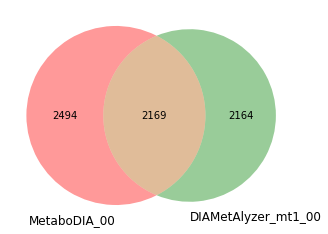

In [3]:
to_plot = mdia_00_oms_mt1_00
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('MetaboDIA_00', 'DIAMetAlyzer_mt1_00'))


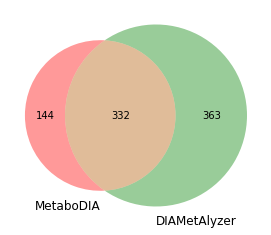

In [4]:

to_plot = mdia_02_oms_mt1_02
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('MetaboDIA', 'DIAMetAlyzer'))

plt.savefig('/Users/alka/Documents/work/projects/DIAMetAlyzer_all/OSW_inkscape/publication/2021/features_library.svg', format="svg")



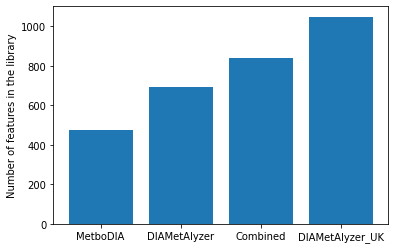

In [5]:
x = ['MetaboDIA', 'DIAMetAlyzer', "Combined", "DIAMetAlyzer_UK"]
ylib = [476, 695, 839, 1048]

fig, ax = plt.subplots() 
plt.bar(x,ylib)

labels = ['n = 476', 'n = 695', 'n = 839', 'n = 1048']
  
plt.ylabel('Number of features in the library') 
   
#plt.show()
plt.savefig('/Users/alka/Documents/work/projects/DIAMetAlyzer_all/OSW_inkscape/publication/2021/features_library.png')


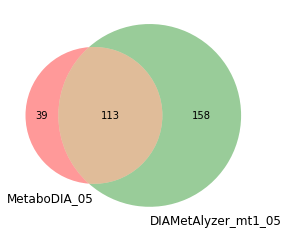

In [6]:
to_plot = mdia_05_oms_mt1_05
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('MetaboDIA_05', 'DIAMetAlyzer_mt1_05'))


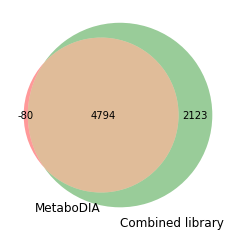

In [7]:
to_plot = mdia_00_comp_mt1_00
overlap_sum_with_mzrt = len(to_plot.overlapping_oms) + len(mzrt_00_comp_mt1_00.overlapping_mdia)
non_overlap_mdia_with_mzrt = len(to_plot.non_overlapping_mdia) - len(mzrt_00_comp_mt1_00.overlapping_mdia)
non_overlap_oms_with_mzrt = len(to_plot.non_overlapping_oms) - len(mzrt_00_comp_mt1_00.overlapping_oms)

venn2(subsets = (non_overlap_mdia_with_mzrt, 
                 non_overlap_oms_with_mzrt,
                 overlap_sum_with_mzrt), 
                 set_labels = ('MetaboDIA', 'Combined library'))

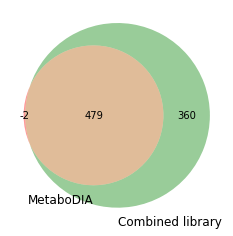

In [8]:
to_plot = mdia_02_comp_mt1_02
overlap_sum_with_mzrt = len(to_plot.overlapping_oms) + len(mzrt_02_comp_mt1_02.overlapping_mdia)
non_overlap_mdia_with_mzrt = len(to_plot.non_overlapping_mdia) - len(mzrt_02_comp_mt1_02.overlapping_mdia)
non_overlap_oms_with_mzrt = len(to_plot.non_overlapping_oms) - len(mzrt_02_comp_mt1_02.overlapping_oms)

venn2(subsets = (non_overlap_mdia_with_mzrt, 
                 non_overlap_oms_with_mzrt,
                 overlap_sum_with_mzrt), 
                 set_labels = ('MetaboDIA', 'Combined library'))
    

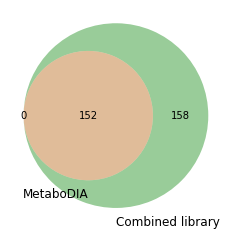

In [9]:
to_plot = mdia_05_comp_mt1_05
overlap_sum_with_mzrt = len(to_plot.overlapping_oms) + len(mzrt_05_comp_mt1_05.overlapping_mdia)
non_overlap_mdia_with_mzrt = len(to_plot.non_overlapping_mdia) - len(mzrt_05_comp_mt1_05.overlapping_mdia)
non_overlap_oms_with_mzrt = len(to_plot.non_overlapping_oms) - len(mzrt_05_comp_mt1_05.overlapping_oms)

venn2(subsets = (non_overlap_mdia_with_mzrt, 
                 non_overlap_oms_with_mzrt,
                 overlap_sum_with_mzrt), 
                 set_labels = ('MetaboDIA', 'Combined library'))

In [10]:
######################## UNKNOWN ########################

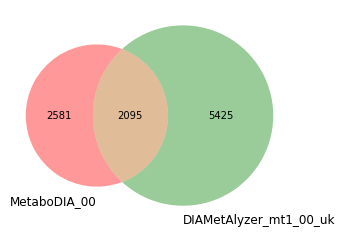

In [11]:
to_plot = mdia_00_oms_mt1_00_uk
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('MetaboDIA_00', 'DIAMetAlyzer_mt1_00_uk'))

## 

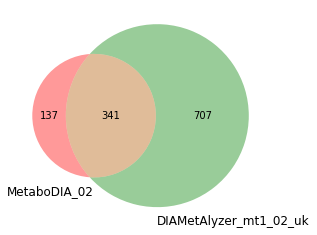

In [12]:
to_plot = mdia_02_oms_mt1_02_uk
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('MetaboDIA_02', 'DIAMetAlyzer_mt1_02_uk'))



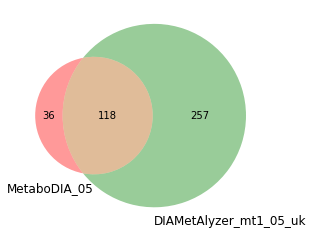

In [13]:
to_plot = mdia_05_oms_mt1_05_uk
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('MetaboDIA_05', 'DIAMetAlyzer_mt1_05_uk'))

# how many of these are filtered due to min. 3 transitions? 

mzrt_mt1_02_k_uk.overlapping_oms:18
mzrt_mt1_02_k_uk.overlapping_mdia:18
mzrt_mt1_02_k_uk_test.overlapping_oms:720
mzrt_mt1_02_k_uk_test.overlapping_mdia:720
10
333
556


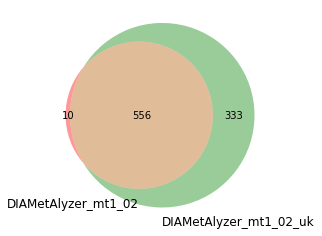

In [15]:
## difference between DIAMetAlyzer known and known_unknwon

inter = intersection(openmslib_mt1_s45_02_ck, openmslib_mt1_s45_02_ck_uk)

oms_intersect = []
oms_diff = []
for element in openmslib_mt1_s45_02_l:
    key = str(str(int(element.precursor_mz)) + "_" + str(element.formulas[0]) + "_" + str(element.adducts[0]))
    if key in inter:
        oms_intersect.append(element)
    else:
        oms_diff.append(element)
    
oms_intersect_uk = []
oms_diff_uk = []
for element in openmslib_mt1_s45_02_uk_l:
    key = str(str(int(element.precursor_mz)) + "_" + str(element.formulas[0]) + "_" + str(element.adducts[0]))
    if key in inter:
        oms_intersect_uk.append(element)
    else:
        oms_diff_uk.append(element)
    
mzrt_mt1_02_k_uk_match = Matches()
mzrt_mt1_02_k_uk_match.overlapping_oms = oms_intersect
mzrt_mt1_02_k_uk_match.non_overlapping_oms = oms_diff
mzrt_mt1_02_k_uk_match.overlapping_mdia = oms_intersect_uk
mzrt_mt1_02_k_uk_match.non_overlapping_mdia = oms_diff_uk

mzrt_mt1_02_k_uk_test = Matches()
mzrt_mt1_02_k_uk_test.non_overlapping_oms = openmslib_mt1_s45_02_l
mzrt_mt1_02_k_uk_test.non_overlapping_mdia = openmslib_mt1_s45_02_uk_l

ppm_dev = 10
rt_dev = 10
mzrt_mt1_02_k_uk = checkStillOverlappingByMzRt(mzrt_mt1_02_k_uk_match, ppm_dev, rt_dev)
print("mzrt_mt1_02_k_uk.overlapping_oms:" + str(len(mzrt_mt1_02_k_uk.overlapping_oms))) # here known
print("mzrt_mt1_02_k_uk.overlapping_mdia:" + str(len(mzrt_mt1_02_k_uk.overlapping_mdia))) # here unknown

ppm_dev = 10
rt_dev = 10
mzrt_mt1_02_k_uk_test = checkStillOverlappingByMzRt(mzrt_mt1_02_k_uk_test, ppm_dev, rt_dev)
print("mzrt_mt1_02_k_uk_test.overlapping_oms:" + str(len(mzrt_mt1_02_k_uk_test.overlapping_oms))) # here known
print("mzrt_mt1_02_k_uk_test.overlapping_mdia:" + str(len(mzrt_mt1_02_k_uk_test.overlapping_mdia))) # here unknown

diff = set(mzrt_mt1_02_k_uk_match.non_overlapping_oms).difference(set(mzrt_mt1_02_k_uk.overlapping_oms))
uk = (len(set(openmslib_mt1_s45_02_ck_uk).difference(openmslib_mt1_s45_02_ck)) - len(set(mzrt_mt1_02_k_uk.overlapping_oms)))
inters = (len(inter) + len(set(mzrt_mt1_02_k_uk.overlapping_oms)))
print(len(diff))
print(uk)
print(inters)

venn2(subsets = (len(diff), 
                 uk,
                 inters), 
                 set_labels = ('DIAMetAlyzer_mt1_02', 'DIAMetAlyzer_mt1_02_uk'))
    
    